In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.utils import compute_class_weight, compute_sample_weight  # to add class balancing in quality calc later

In [2]:
random.seed(42)
np.random.seed(42)

In [3]:
class Node:
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index 
        self.t = t  
        self.true_branch = true_branch  
        self.false_branch = false_branch

In [4]:
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.prediction()
        
    def prediction(self):
        counts = np.bincount(self.labels)
        return np.argmax(counts)     

In [5]:
class ForestClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, min_samples_split=2, min_samples_leaf=1, max_depth=50, n_trees=10, out_of_bag=False,
                 scoring=accuracy_score, criterion='gini'):
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_depth = max_depth
        self.forest = None
        self.n_trees = n_trees
        self.out_of_bag = out_of_bag
        self.oob_bootstrap = None
        self.scoring = scoring
        self.criterion = criterion
        self.mtx = None
        self.oob_accuracy = []
        self.oob_score_ = 0.

    def calc_impurity(self, labels):
        classes = np.bincount(labels)
        p = classes / len(labels)
        if self.criterion == 'gini':
            impurity = 1     
            impurity -= np.sum(np.power(p, 2))
        elif self.criterion == 'entropy':
            impurity = 0
            impurity -= np.sum(p*np.log2(p+1e-15))
        else:
            raise ValueError(f'Criterion should be "gini" or "entropy", {self.criterion} is given')
        
        return impurity

    def quality(self, left_labels, right_labels, current):
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
        return current - p * self.calc_impurity(left_labels) - (1 - p) * self.calc_impurity(right_labels)

    def split(self, data, labels, index, t):
        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)
        
        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]
        
        return true_data, false_data, true_labels, false_labels

    def get_bootstrap(self, data, labels, N, out_of_bag):
        random.seed(42)
        n_samples = data.shape[0]
        bootstrap, oob_samples = [], []
        self.mtx = np.zeros((self.n_trees, data.shape[0]), dtype=np.int8)
        self.mtx[:] = -2
        oob_indices = []
    
        for i in range(N):
            b_data = np.zeros_like(data)
            b_labels = np.zeros_like(labels)
            bootstrap_indices = []

            for j in range(n_samples):
                sample_index = random.randint(0, n_samples-1)
                bootstrap_indices.append(sample_index)
                b_data[j] = data[sample_index]
                b_labels[j] = labels[sample_index]
            bootstrap.append((b_data, b_labels))

            if out_of_bag:
                indices = [i for i in range(n_samples) if i not in bootstrap_indices]
                self.mtx[i, indices] = -1
                oob_data = data[indices]
                oob_labels = labels[indices]
                oob_samples.append((oob_data, oob_labels))
                oob_indices.append(indices)
        
        return bootstrap, oob_samples, oob_indices

    @staticmethod
    def get_subsample(len_sample):
        sample_indexes = [i for i in range(len_sample)]
    
        len_subsample = int(np.sqrt(len_sample))
        subsample = []
    
        random.shuffle(sample_indexes)
        for _ in range(len_subsample):
            subsample.append(sample_indexes.pop())
        
        return subsample

    def find_best_split(self, data, labels):

        current_gini = self.calc_impurity(labels)

        best_quality = 0
        best_t = None
        best_index = None
    
        n_features = data.shape[1]
    
        subsample = self.get_subsample(n_features)
    
        for index in subsample:

            t_values = np.unique([row[index] for row in data])
        
            for t in t_values:

                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)

                if len(true_data) < self.min_samples_leaf or len(false_data) < self.min_samples_leaf:
                    continue
            
                current_quality = self.quality(true_labels, false_labels, current_gini)
            
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index

    def build_tree(self, data, labels, current_depth=1, max_depth=None):
        if data.shape[0] < self.min_samples_split:
            return Leaf(data, labels)

        quality, t, index = self.find_best_split(data, labels)

        if quality == 0:
            return Leaf(data, labels)
        elif current_depth >= self.max_depth:
            return Leaf(data, labels)

        current_depth += 1

        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)

        true_branch = self.build_tree(true_data, true_labels, current_depth=current_depth, max_depth=self.max_depth)
        false_branch = self.build_tree(false_data, false_labels, current_depth=current_depth, max_depth=self.max_depth)

        return Node(index, t, true_branch, false_branch)

    def fit(self, X, y=None):
        self.forest = []
        pred = np.zeros_like(y).astype(float)
        freq = np.zeros_like(y)
        bootstrap, self.oob_bootstrap, oob_indices = self.get_bootstrap(X, y, self.n_trees, self.out_of_bag)

        for i, (b_data, b_labels) in enumerate(bootstrap):
            tree = self.build_tree(b_data, b_labels)
            self.forest.append(tree)
            if self.out_of_bag:
                y_pred = self.predict_one_tree(self.oob_bootstrap[i][0], tree)
                pred[oob_indices[i]] += np.abs(self.oob_bootstrap[i][1].astype(float)==y_pred).astype(float)
                freq[oob_indices[i]] += 1
        self.oob_score_ = np.mean(pred/freq)

        if self.out_of_bag:
            mean_scores, preds = self.get_oob_scores()
            self.oob_accuracy.append(self.scoring(y, preds))
            self.oob_accuracy.append(mean_scores)
        
        return self

    def get_oob_scores(self):
        if self.out_of_bag:
            oob_accuracies = []
            for i in range(self.n_trees):
                data, labels = self.oob_bootstrap[i]
                preds = self.predict_one_tree(data, self.forest[i])
                self.mtx[i, self.mtx[i] == -1] = preds
                oob_accuracies.append(self.scoring(labels, preds))
            votes = np.apply_along_axis(lambda x: np.argmax(np.bincount(x[x!=-2])), axis=0, arr=self.mtx)
            oob_accuracy = np.array(oob_accuracies).mean()
            return oob_accuracy, votes
        else:
            return None, None

    def predict_one_value(self, obj, node):

        if isinstance(node, Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.predict_one_value(obj, node.true_branch)
        else:
            return self.predict_one_value(obj, node.false_branch)

    def predict_one_tree(self, X, tree):
        values = []
        for obj in X:
            prediction = self.predict_one_value(obj, tree)
            values.append(prediction)
        return np.array(values)

    def predict(self, X):
        predictions = []
        for tree in self.forest:
            predictions.append(self.predict_one_tree(X, tree))

        predictions = np.asarray(predictions).T
        vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=1, arr=predictions)
        
        return vote
    
    def predict_proba(self, X):
        predictions = []
        for tree in self.forest:
            predictions.append(self.predict_one_tree(X, tree))
        predictions = np.asarray(predictions).T
        class_probs = np.sum(predictions, axis=1) / len(self.forest)
        return class_probs

In [6]:
X, y =  datasets.make_classification(n_samples=500, n_features=5, n_informative=5, n_classes=2, n_redundant=0, 
                                     n_clusters_per_class=1, random_state=23)

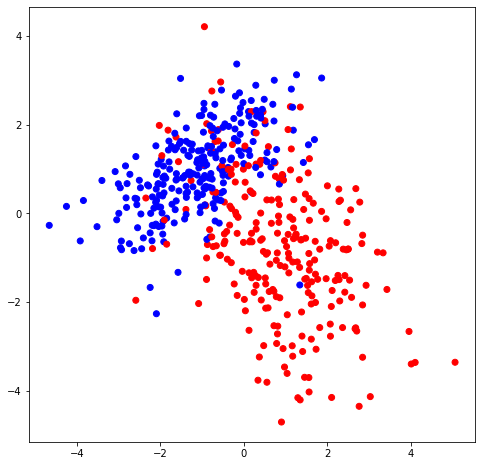

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], X)), list(map(lambda x: x[1], X)), c=y, cmap=ListedColormap(['red', 'blue']))
plt.show()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [9]:
forest = ForestClassifier(n_trees=50)

forest.fit(X_train, y_train)
train_pred = forest.predict(X_train)
test_pred = forest.predict(X_test)

print(classification_report(y_train, train_pred, digits=3))
print(classification_report(y_test, test_pred, digits=3))

              precision    recall  f1-score   support

           0      1.000     1.000     1.000       168
           1      1.000     1.000     1.000       182

    accuracy                          1.000       350
   macro avg      1.000     1.000     1.000       350
weighted avg      1.000     1.000     1.000       350

              precision    recall  f1-score   support

           0      0.987     0.939     0.963        82
           1      0.931     0.985     0.957        68

    accuracy                          0.960       150
   macro avg      0.959     0.962     0.960       150
weighted avg      0.962     0.960     0.960       150



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:152: RuntimeWarning: invalid value encountered in true_divide


In [10]:
labels = np.where(forest.predict_proba(X_test)>=0.5,1,0)
accuracy_score(y_test, labels)

0.9666666666666667

In [ ]:
extra_forest = ExtraTreesClassifier(n_estimators=50, max_features=None, max_depth=50)

extra_forest.fit(X_train, y_train)
train_pred = extra_forest.predict(X_train)
test_pred = extra_forest.predict(X_test)

print(classification_report(y_train, train_pred, digits=3))
print(classification_report(y_test, test_pred, digits=3))

              precision    recall  f1-score   support

           0      1.000     1.000     1.000       168
           1      1.000     1.000     1.000       182

    accuracy                          1.000       350
   macro avg      1.000     1.000     1.000       350
weighted avg      1.000     1.000     1.000       350

              precision    recall  f1-score   support

           0      1.000     0.976     0.988        82
           1      0.971     1.000     0.986        68

    accuracy                          0.987       150
   macro avg      0.986     0.988     0.987       150
weighted avg      0.987     0.987     0.987       150



In [ ]:
X, y = datasets.make_classification(n_samples=1000, n_features=2, n_informative=2, n_classes=2, n_redundant=0, 
                                    n_clusters_per_class=1, random_state=10)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

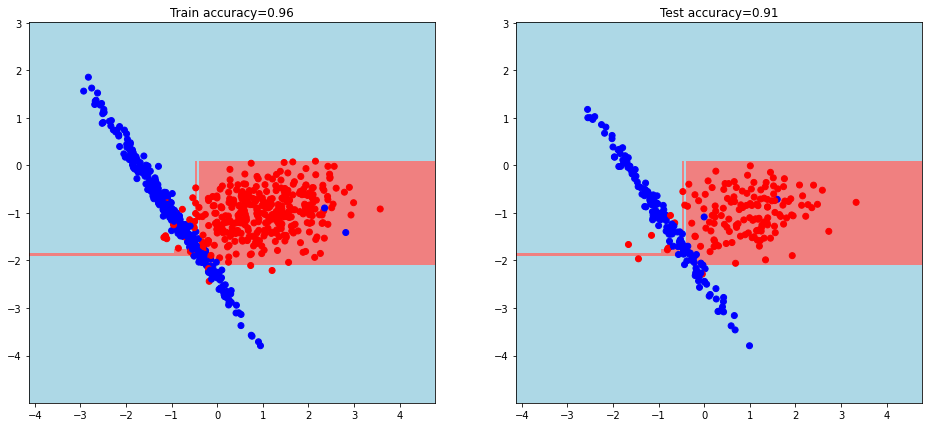

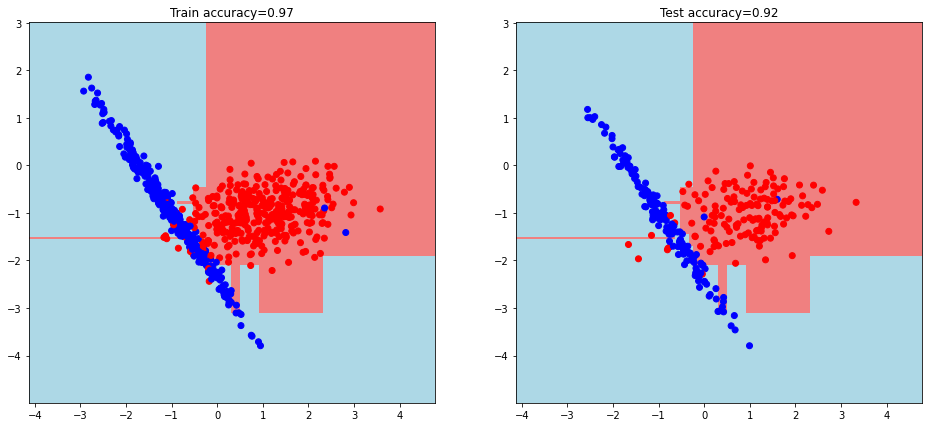

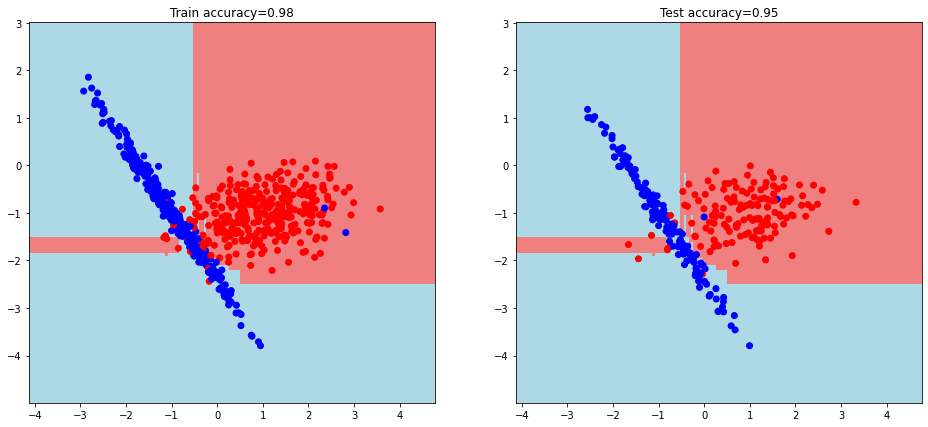

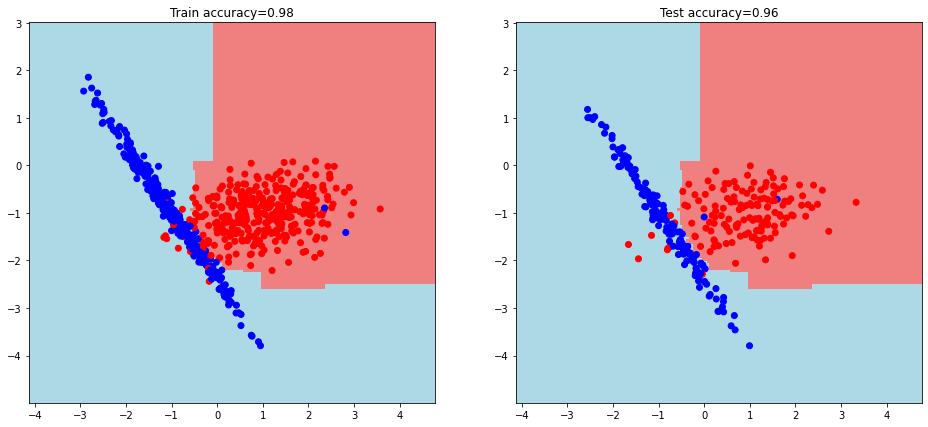

In [ ]:
n_trees = [1, 3, 10, 50]
classifiers = [ForestClassifier(n_trees=i, min_samples_leaf=5).fit(X_train, y_train) for i in n_trees]
#classifiers = [ExtraTreesClassifier(n_estimators=i).fit(X_train, y_train) for i in n_trees]

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


for clf in classifiers:
    plt.figure(figsize = (16, 7))
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(X_train)
    mesh_predictions = np.array(clf.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=colors)
    plt.title(f'Train accuracy={accuracy_score(y_train, clf.predict(X_train)):.2f}')

    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap = colors)
    plt.title(f'Test accuracy={accuracy_score(y_test, clf.predict(X_test)):.2f}')

Точность модели возрастает при увеличении числа деревьев в нём. При увеличении количества деревьев модель заметно меньше переобучается.

In [ ]:
oob_forest = ForestClassifier(n_trees=50, out_of_bag=True, scoring=accuracy_score, criterion='entropy')

oob_forest.fit(X, y)
preds = oob_forest.predict(X)

print(classification_report(y, preds, digits=3))
print(f'Out-of-bag accuracy: {oob_forest.oob_accuracy[1]:.3f}, out-of-bag alt.: {oob_forest.oob_accuracy[0]}')
print(f'Last oob_score: {oob_forest.oob_score_}')
# alternative out-of-bag: we predict all instances in X by trees that have not seen such instances during fit,
# get predicted label by voting of these trees and compare the voting result with the ground truth
# on the whole target training set
# in first case we predict every oob set by tree that has not fitted with this set, calculate accuracy
# and then taking average accuracy from all ensemble of trees

              precision    recall  f1-score   support

           0      0.998     1.000     0.999       498
           1      1.000     0.998     0.999       502

    accuracy                          0.999      1000
   macro avg      0.999     0.999     0.999      1000
weighted avg      0.999     0.999     0.999      1000

Out-of-bag accuracy: 0.938, out-of-bag alt.: 0.963
Last oob_score: 0.9369773343439265


In [ ]:
oob_sk_forest = RandomForestClassifier(n_estimators=50, oob_score=True, criterion='entropy', min_samples_leaf=5,
                                       random_state=11)

oob_sk_forest.fit(X, y)
preds = oob_sk_forest.predict(X)

print(classification_report(y, preds, digits=3))
print(f'Out-of-bag accuracy: {oob_sk_forest.oob_score_}')

              precision    recall  f1-score   support

           0      0.992     0.960     0.976       498
           1      0.961     0.992     0.976       502

    accuracy                          0.976      1000
   macro avg      0.977     0.976     0.976      1000
weighted avg      0.976     0.976     0.976      1000

Out-of-bag accuracy: 0.962


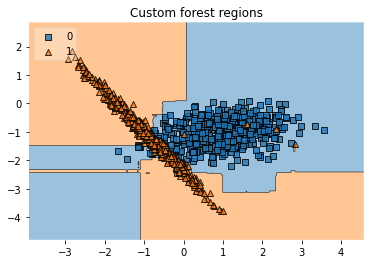

In [ ]:
from mlxtend.plotting import plot_decision_regions
import warnings
warnings.filterwarnings('ignore')

plot_decision_regions(X, y, clf=oob_forest, legend=2)

plt.title('Custom forest regions')
plt.show()

In [ ]:
oob_forest = ForestClassifier(n_trees=50, out_of_bag=True, min_samples_leaf=5, scoring=accuracy_score, 
                              criterion='entropy')

oob_forest.fit(X_train, y_train)
train_preds = oob_forest.predict(X_train)
preds = oob_forest.predict(X_test)

print(classification_report(y_train, train_preds, digits=3))
print(classification_report(y_test, preds, digits=3))
print(f'Out-of-bag accuracy: {oob_forest.oob_accuracy[1]:.3f}, out-of-bag alt.: {oob_forest.oob_accuracy[0]}')
print(f'Last oob_score: {oob_forest.oob_score_}')

              precision    recall  f1-score   support

           0      0.991     0.961     0.976       356
           1      0.961     0.991     0.976       344

    accuracy                          0.976       700
   macro avg      0.976     0.976     0.976       700
weighted avg      0.976     0.976     0.976       700

              precision    recall  f1-score   support

           0      0.971     0.944     0.957       142
           1      0.951     0.975     0.963       158

    accuracy                          0.960       300
   macro avg      0.961     0.959     0.960       300
weighted avg      0.960     0.960     0.960       300

Out-of-bag accuracy: 0.923, out-of-bag alt.: 0.9542857142857143
Last oob_score: 0.9215267888094894


In [ ]:
oob_sk_forest = RandomForestClassifier(n_estimators=50, oob_score=True, criterion='entropy', min_samples_leaf=5,
                                       random_state=11)

oob_sk_forest.fit(X_train, y_train)
train_preds = oob_sk_forest.predict(X_train)
preds = oob_sk_forest.predict(X_test)

print(classification_report(y_train, train_preds, digits=3))
print(classification_report(y_test, preds, digits=3))
print(f'Out-of-bag accuracy: {oob_sk_forest.oob_score_}')

              precision    recall  f1-score   support

           0      0.994     0.949     0.971       356
           1      0.950     0.994     0.972       344

    accuracy                          0.971       700
   macro avg      0.972     0.972     0.971       700
weighted avg      0.972     0.971     0.971       700

              precision    recall  f1-score   support

           0      0.978     0.944     0.961       142
           1      0.951     0.981     0.966       158

    accuracy                          0.963       300
   macro avg      0.965     0.962     0.963       300
weighted avg      0.964     0.963     0.963       300

Out-of-bag accuracy: 0.9542857142857143
